In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage, compute_usage
%matplotlib inline
import datetime

In [2]:
# plot/colors definitions
cpath = '/n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana'
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

sns.set_style('white')

In [3]:
import warnings

# Binning / smoothing
    
def firing_rates(
    spike_times, 
    spike_labels, 
    window_size=0.2, 
    window_step=0.02
):
    """Convert spike tikes to firing rates using a sliding window
    
    Parameters
    ----------
    spike_times : ndarray
        Spike times (in seconds) for all units. The source of each spike is
        input separately using ``spike_labels``
        
    spike_labels: ndarray
        The source/label for each spike in ``spike_times``. The maximum
        value of this array determines the number of rows in the heatmap.
    
    window_size: float, default=0.2
        Length (in seconds) of the sliding window used to calculate firing rates
        
    window_step: float, default=0.02
        Step-size (in seconds) between each window used to calculate firing rates
    Returns
    -------
    firing_rates: ndarray
        Array of firing rates, where rows units and columns are sliding 
        window locations. ``firing_rates`` has shape ``(N,M)`` where::
            N = max(spike_labels)+1
            M = (max(spike_times)-min(spike_times))/binsize
    start_time, float
        The time (in seconds) corresponding to the left-boundary
        of the first window in ``firing_rates``.
    """
    # round spikes to window_step and factor our start time
    spike_times = np.around(spike_times/window_step).astype(int)
    start_time = spike_times.min()
    spike_times = spike_times - start_time
    
    # create heatmap of spike counts for each window_step-sized bin
    spike_labels = spike_labels.astype(int)
    heatmap = np.zeros((spike_labels.max()+1, spike_times.max()+1))
    np.add.at(heatmap, (spike_labels, spike_times), 1/window_step)
    
    # use convolution to get sliding window counts
    kernel = np.ones(int(window_size//window_step))/(window_size//window_step)
    for i in range(heatmap.shape[0]): heatmap[i,:] = np.convolve(heatmap[i,:],kernel, mode='same')
    return heatmap, start_time-window_step/2


def bin_data(
    data, 
    binsize,
    axis=-1,
    return_intervals=False
):
    """Bin data using non-overlaping windows along `axis`
    Returns
    -------
    data_binned: ndarray
    bin_intervals: ndarray (returned if ``rerturn_intervals=True``)
        (N,2) array with the start and end index of each bin
    """
    data = np.moveaxis(data,axis,-1)
    pad_amount = (-data.shape[-1])%binsize
    num_bins = int((data.shape[-1]+pad_amount)/binsize)

    data_padded = np.pad(data,[(0,0)]*(len(data.shape)-1)+[(0,pad_amount)])
    data_binned = data_padded.reshape(*data.shape[:-1], num_bins, binsize).mean(-1)
    if pad_amount > 0: data_binned[...,-1] = data_binned[...,-1] * binsize/(binsize-pad_amount)
    data_binned = np.moveaxis(data_binned,-1,axis)

    if return_intervals:
        bin_starts = np.arange(0,num_bins)*binsize
        bin_ends = np.arange(1,num_bins+1)*binsize
        bin_ends[-1] = data.shape[-1]
        bin_intervals = np.vstack((bin_starts,bin_ends)).T
        return data_binned, bin_intervals
    else: return data_binned



# Normalization

def zscore(data, axis=0, eps=1e-10):
    """
    Z-score standardize the data along ``axis``
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True) + eps
    return (data-mean)/std


# Dimensionality reduction

def sort(
    data, 
    method='rastermap', 
    options={}
):
    """Compute neuron ordering that groups neurons with similar activity
    Parameters
    ----------
    data: ndarray
        Data matrix where rows are neurons and columns are time points
    method: {'rastermap'}
        Method to use for sorting (currently only rastermap is implemented)
    options: dict, default={}
        Sorting method-specific options.
        'rastermap'
            ``options`` will be passed as keyword arguments when initializing
            `rastermap.mapping.Rastermap <https://github.com/MouseLand/rastermap/blob/40867ce9a8b2850d76483890740c0dc10d6cb413/rastermap/mapping.py#L531>`_
    Returns
    -------
    ordering: ndarray
        Ordering index that can be used for sorting (see `numpy.argsort`)
    """
    valid_sort_methods = ['rastermap']
    if not method in valid_sort_methods:
        raise AssertionError(method+' is not a valid sort method. Must be one of '+repr(valid_sort_methods))
    if method=='rastermap':
        print('Computing row order with rastermap')
        from rastermap import mapping
        model = mapping.Rastermap(n_components=1).fit(data)
        return np.argsort(model.embedding[:,0])


def umap_embedding(
    data, 
    standardize=True,
    n_pcs=20, 
    n_components=2, 
    n_neighbors=100,
    random_state=42,
    **kwargs
):
    """Generate a 2D embedding of neural activity using UMAP. The function 
    generates the embedding in three steps:
        1. (Optionally) standardize (Z-score) the activity of each neuron
        2. Perform initial dimensionality reduction using PCA
        3. Run UMAP on the output of PCA
    Parameters
    ----------
    data: ndarray
        Array of neural activity where rows are neurons and columns are time points
    standardize: bool, default=True
        Whether to standardize (Z-score) the data prior to PCA
    n_pcs: int, default=20
        Number of principal components to use during PCA. If ``n_pcs=None``, the binned 
        data will be passed directly to UMAP
    n_components: int, default=2
        Dimensionality of the embedding
    n_neighbors: int, default=100
        Passed to UMAP (see `explanation of UMAP parameters <https://umap-learn.readthedocs.io/en/latest/parameters.html>`_).
    **kwargs
        Any other UMAP parameters can also be passed as keyword arguments
    Returns
    -------
    coodinates: ndarray
        (N,2) array containing UMAP coordinates
    """
    from sklearn.decomposition import PCA
    from umap import UMAP

    if standardize: data = zscore(data, axis=1)
    PCs = PCA(n_components=n_pcs).fit_transform(data.T)
    umap_obj = UMAP(n_neighbors=n_neighbors, n_components=n_components, n_epochs=500,random_state=random_state,**kwargs)
    coordinates = umap_obj.fit_transform(PCs)
    return coordinates

In [4]:
## for males

In [5]:
## upload data frame females
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/longtogeny_musages_mtx_all.parquet')
mdf_all = pd.read_parquet(path)
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/longtogeny_musages_mtx_most_used.parquet')
mdf = pd.read_parquet(path)

In [6]:
## filter out bad days - 
#bad_session=[221, 228]
#bad_syllable=[44,89]
#bad_syllable=[44]
#temp = mdf.loc[~mdf.index.isin(list(bad))]
#mdf.drop(bad_session, level=0, axis=0, inplace=True)
#mdf.drop(bad_syllable, axis=1, inplace=True)

In [7]:
df_indv=mdf.groupby(['mouse','age']).mean()

In [8]:
## umap

In [9]:
temp=mdf.copy()
mdf.drop('04_01', level=1, axis=0, inplace=True) ##remove annoying mouse!!

In [10]:
# syllbles by age males
data_umap= mdf.copy().to_numpy()
data_umap_labels = mdf.index.get_level_values(0).to_numpy()

In [11]:
# transform age mice to labels
from sklearn.preprocessing import StandardScaler, LabelEncoder
exp = np.unique(data_umap_labels)
le = LabelEncoder()
le.fit(exp)
y = le.transform(data_umap_labels)

In [12]:
# sort frequencies by mouse
coordinates = umap_embedding(data_umap.T, 
        standardize=True,
        n_pcs=None, 
        n_components=2, 
        n_neighbors=20,
        random_state=0)

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distanc

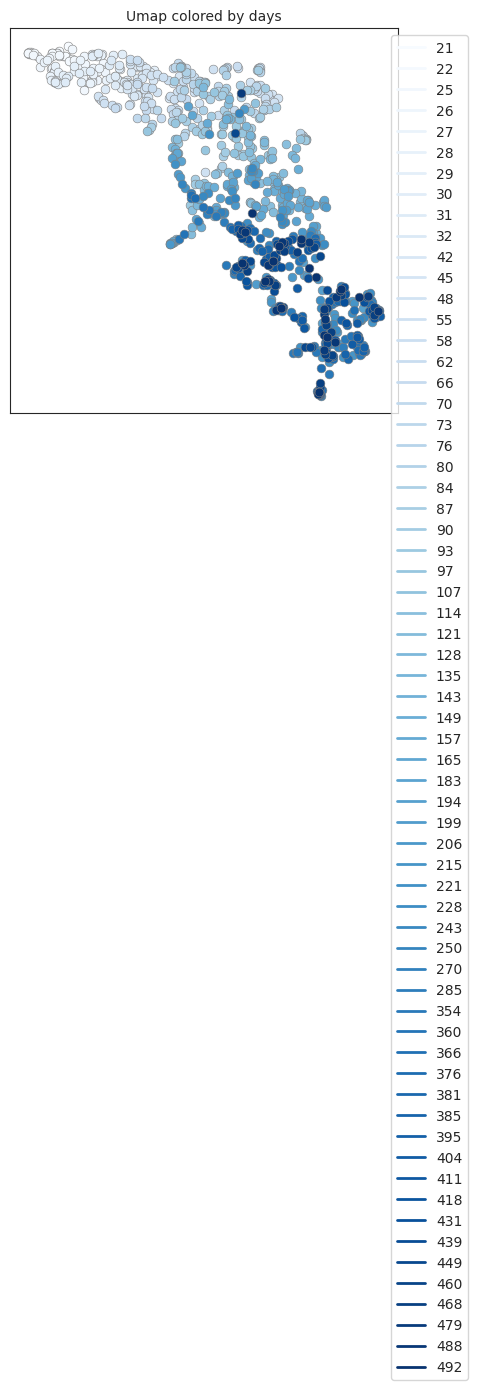

In [13]:
# variables to plot
import colorcet as cc
cmap2 = cc.blues
#cmap2 = 'Blues'
# syllbles by age males
data_labels = mdf.index.get_level_values(0).to_numpy()

cmap2 = mpl.cm.Blues
ages = np.unique(data_labels)
colors = np.arange(0, 256, math.ceil(256/len(ages)))

# create age labels colors
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        #n=n+1
        #print(n)
        color_mat.append(cmap2(c))
        
lines=[]
# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))

fig, ax = plt.subplots()
fig.set_size_inches(5,5) 
plt.legend(handles=lines,labels=list(exp),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by days',fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=lines[y[i]].get_color(),
                edgecolor='gray',
                linewidth=0.4,
                s=40)
#fig.savefig(data_loc + 'umap_indv.pdf', bbox_inches='tight')

In [14]:
## colored by individuals
data_umap_labels = mdf.index.get_level_values(1).to_numpy()
exp = np.unique(data_umap_labels)
le = LabelEncoder()
le.fit(exp)
y = le.transform(data_umap_labels)

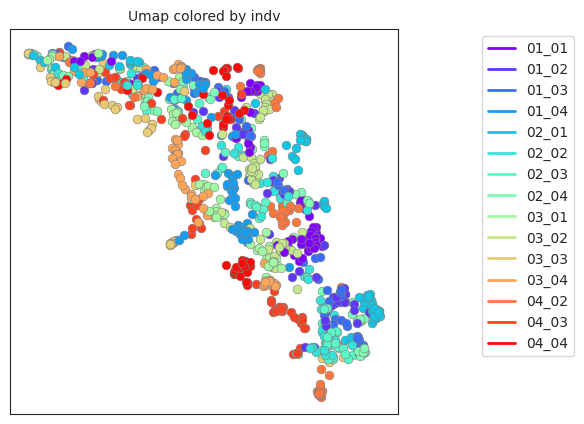

In [15]:
# variables to plot
import colorcet as cc
cmap2 = cc.glasbey
#cmap2 = 'Blues'

cmap2 = mpl.cm.rainbow
ages = np.unique(data_umap_labels)
colors = np.arange(0, 256, math.ceil(256/len(ages)))

# create age labels colors
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        #n=n+1
        #print(n)
        color_mat.append(cmap2(c))
        
lines=[]
# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))

fig, ax = plt.subplots()
fig.set_size_inches(5,5) 
plt.legend(handles=lines,labels=list(exp),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by indv',fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=lines[y[i]].get_color(),
                edgecolor='gray',
                linewidth=0.4,
                s=40)
#fig.savefig(data_loc + 'umap_indv.pdf', bbox_inches='tight')

In [16]:
df=pd.DataFrame()
df['0'] = coordinates[:,0]
df['1'] = coordinates[:,1]
df['mouse'] = mdf.index.get_level_values(1).to_numpy()
df['days'] = mdf.index.get_level_values(0).to_numpy()

<Axes: xlabel='0', ylabel='1'>

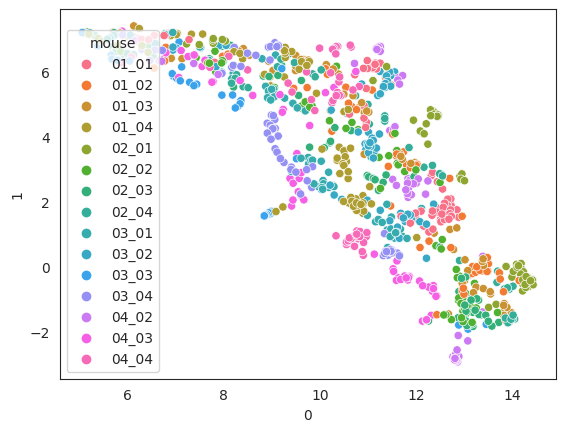

In [17]:
sns.scatterplot(data=df,x='0',y='1',hue='mouse')

<Axes: xlabel='0', ylabel='1'>

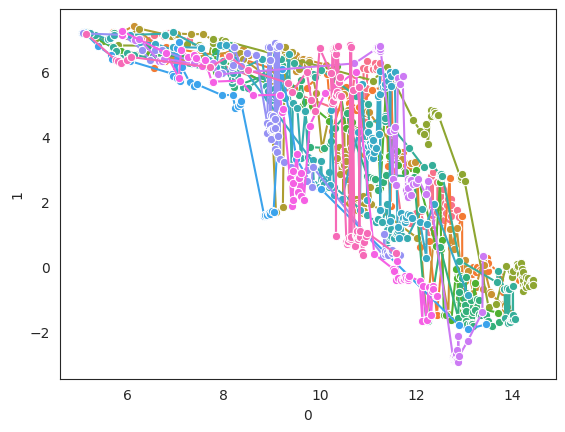

In [18]:
sns.lineplot(data=df,x='0',y='1',hue='mouse',marker='o',legend=False)

<Axes: xlabel='0', ylabel='1'>

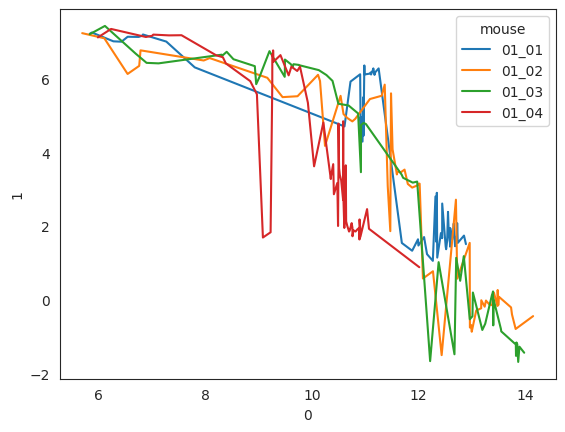

In [19]:
sns.lineplot(data=df,x='0',y='1',hue='mouse',hue_order=['01_01','01_02','01_03','01_04'])

<Axes: xlabel='0', ylabel='1'>

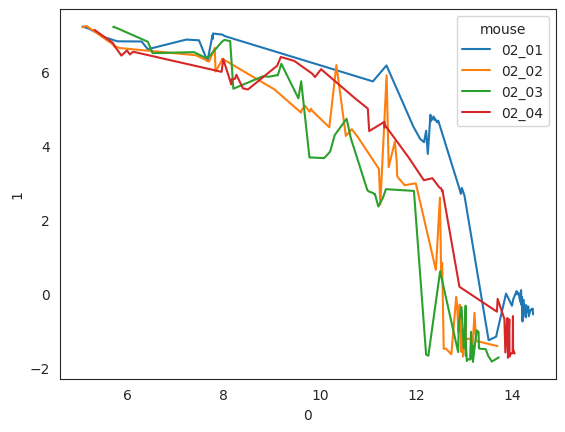

In [20]:
sns.lineplot(data=df,x='0',y='1',hue='mouse',hue_order=['02_01','02_02','02_03','02_04'])

<Axes: xlabel='0', ylabel='1'>

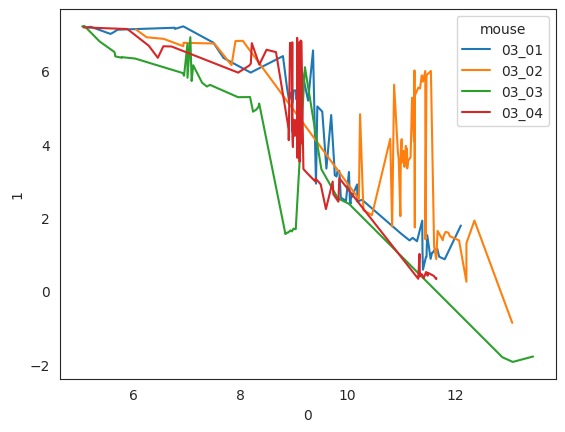

In [21]:
sns.lineplot(data=df,x='0',y='1',hue='mouse',hue_order=['03_01','03_02','03_03','03_04'])

In [22]:
### create movie
df

,0,1,mouse,days
0,5.880433,7.236295,01_01,21
1,6.113627,7.079599,01_02,21
2,6.125138,7.414042,01_03,21
3,5.993412,7.102936,01_04,21
4,5.084452,7.200374,02_01,21
...,...,...,...,...
889,11.735992,1.491800,03_02,492
890,11.386114,0.452886,03_04,492
891,12.810805,-2.837494,04_02,492
892,11.794359,-0.358007,04_03,492


In [23]:
from collections import Counter
Counter(df.mouse)

Counter({'02_01': 64,
         '03_01': 64,
         '01_01': 63,
         '02_03': 63,
         '01_03': 62,
         '01_04': 62,
         '02_02': 62,
         '03_02': 62,
         '03_04': 61,
         '04_02': 61,
         '01_02': 60,
         '04_04': 59,
         '04_03': 58,
         '02_04': 51,
         '03_03': 42})

/tmp/ipykernel_30808/3546497340.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


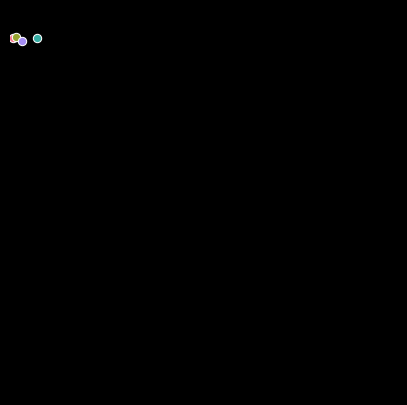

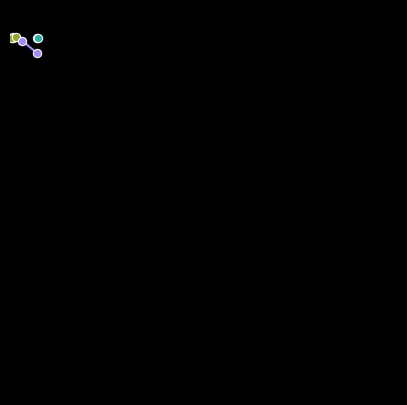

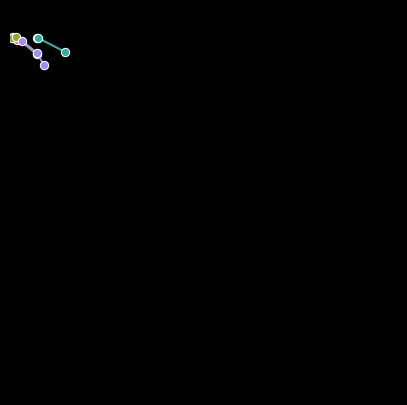

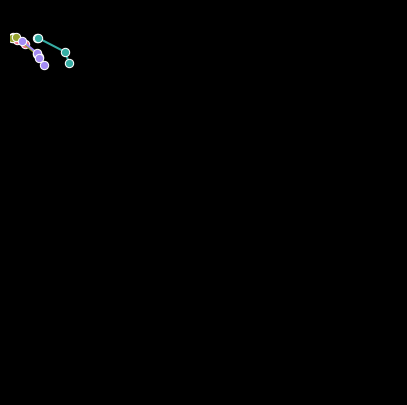

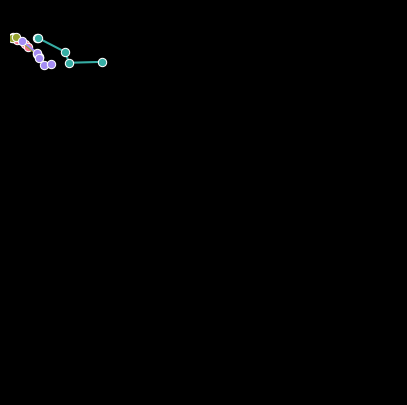

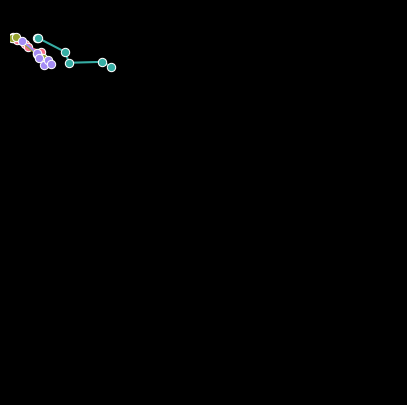

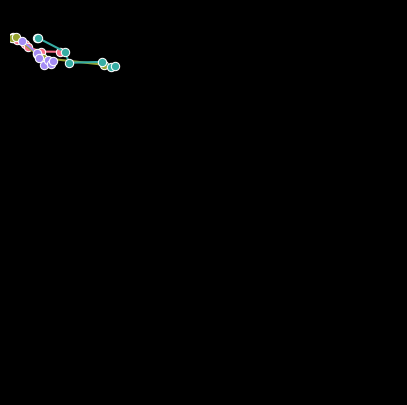

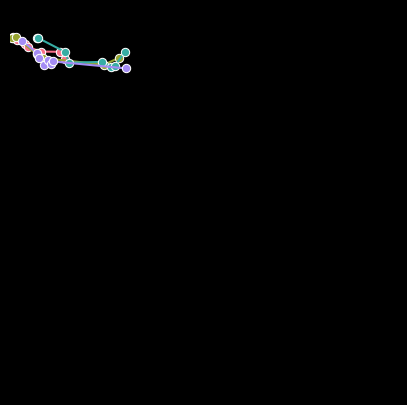

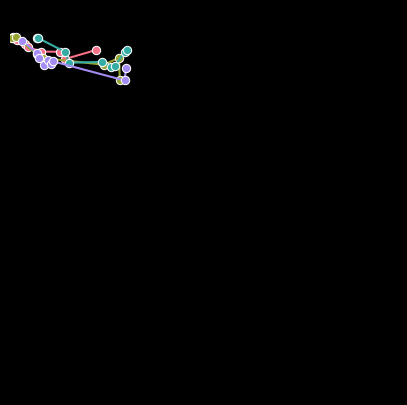

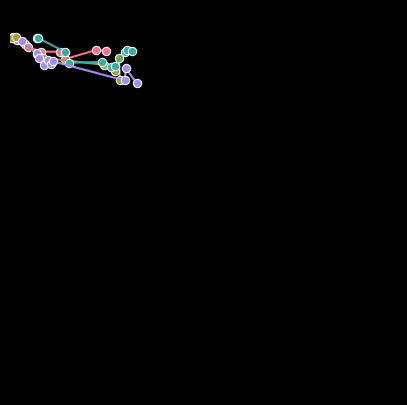

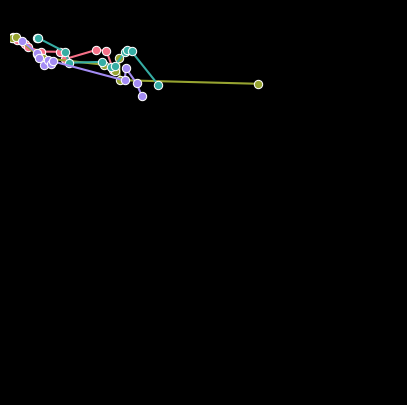

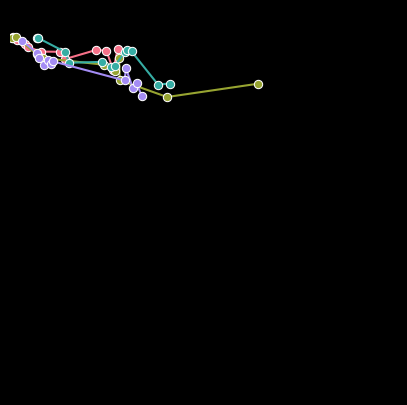

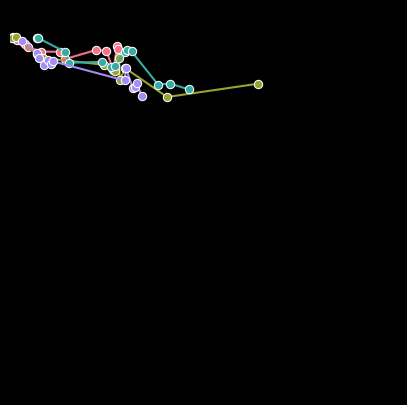

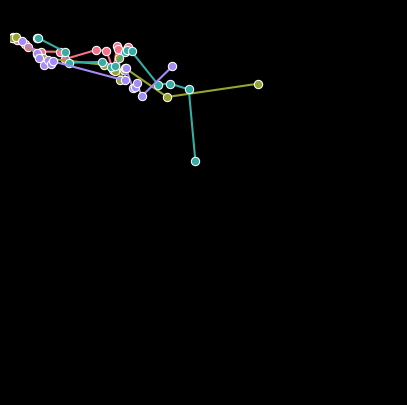

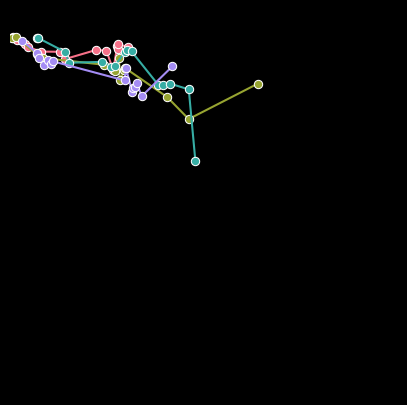

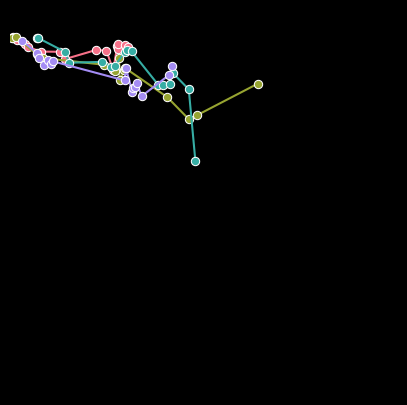

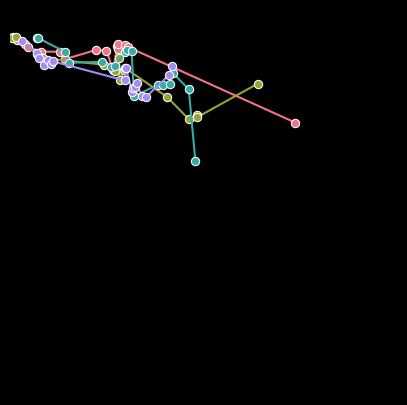

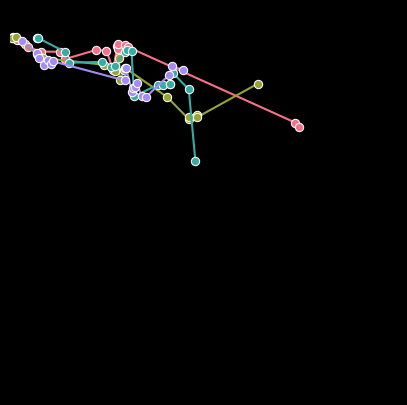

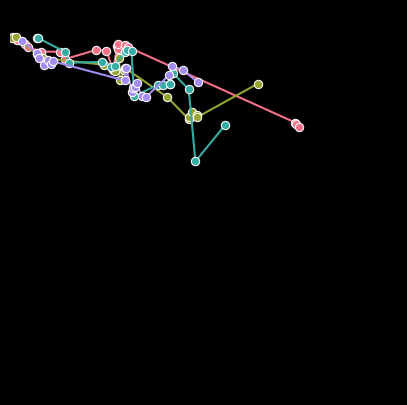

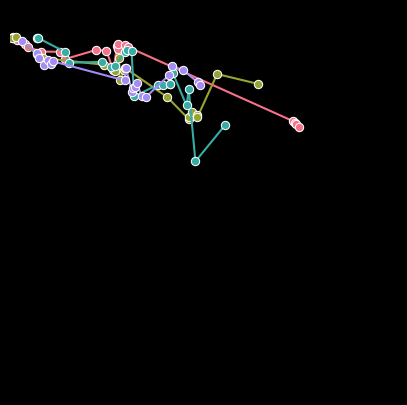

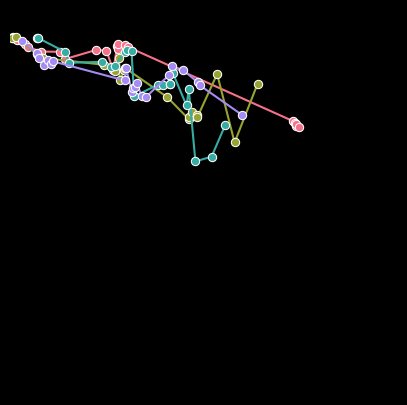

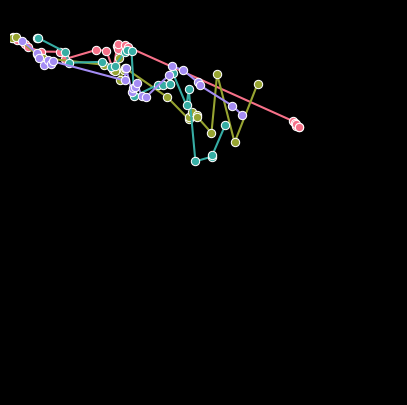

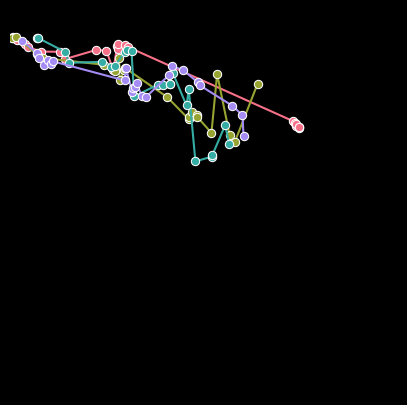

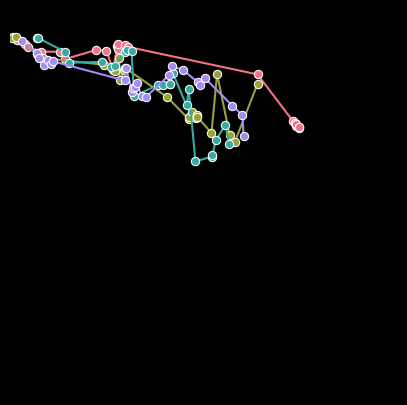

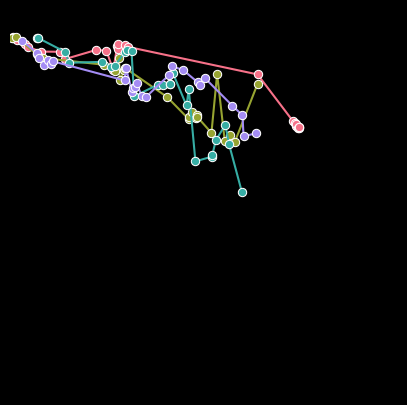

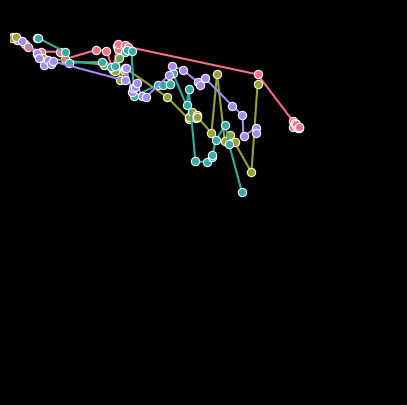

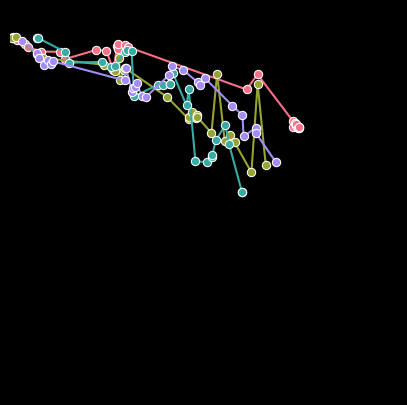

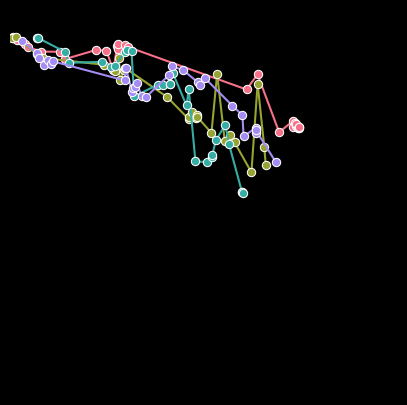

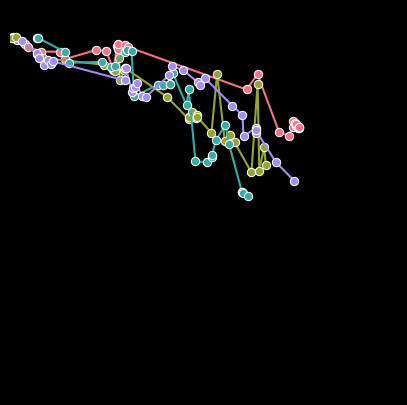

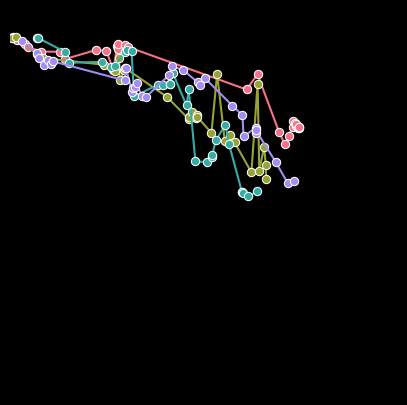

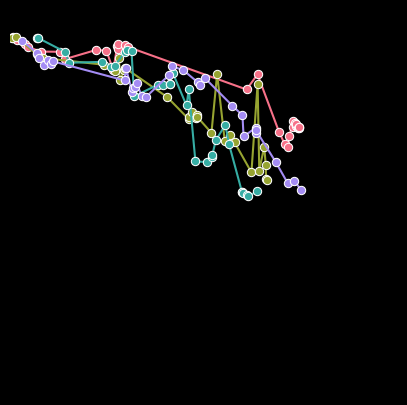

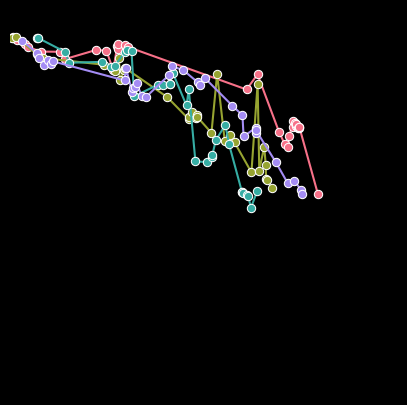

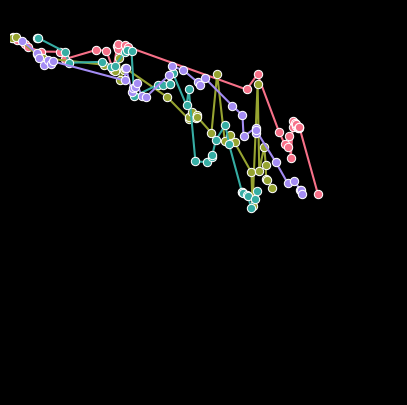

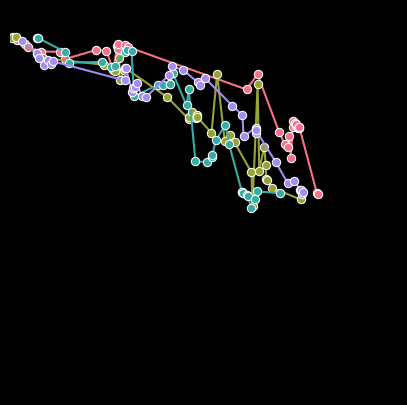

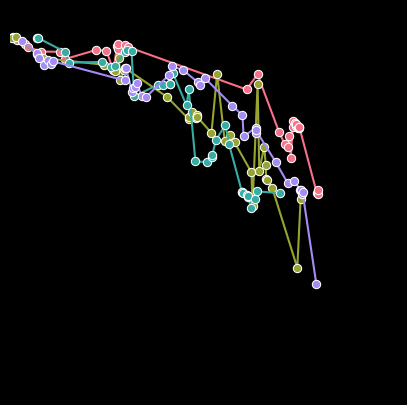

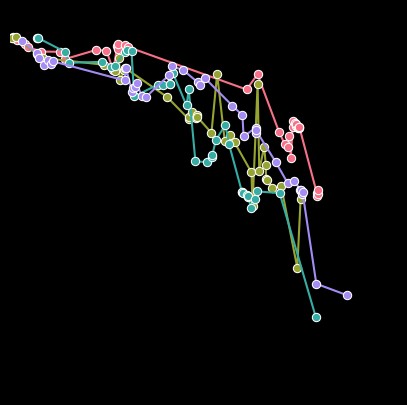

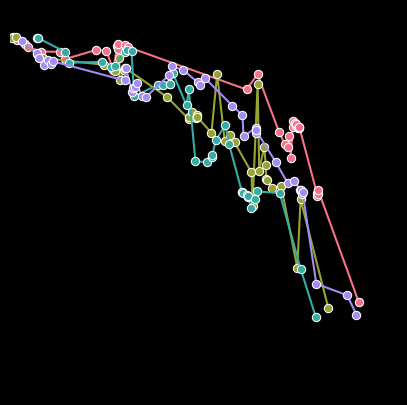

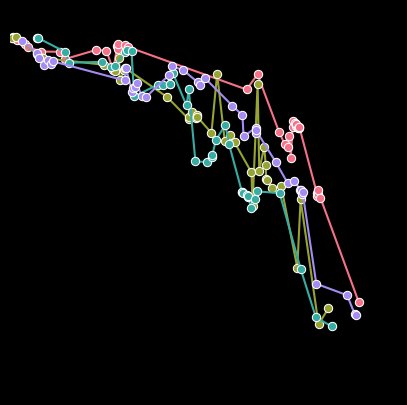

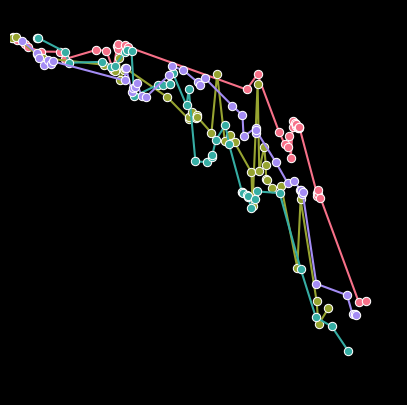

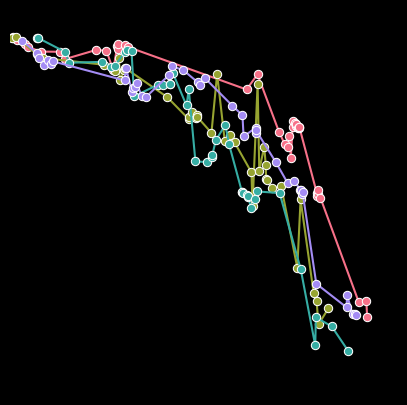

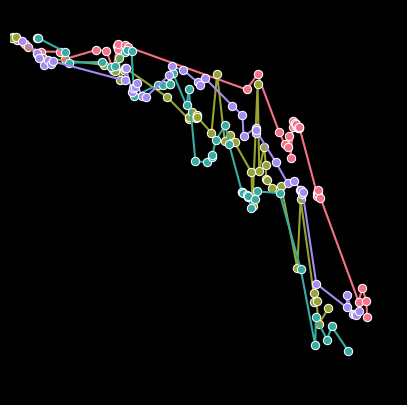

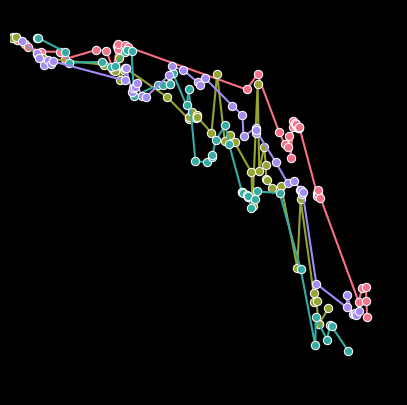

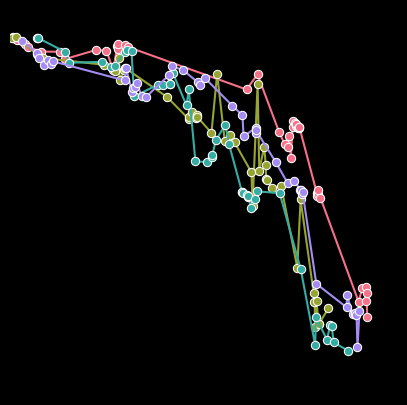

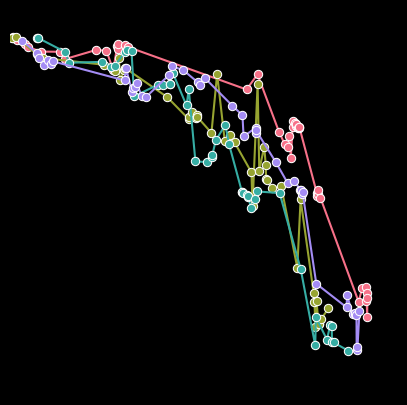

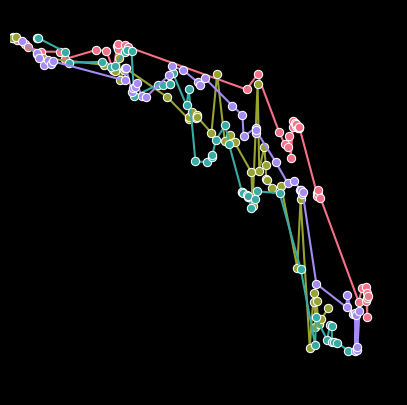

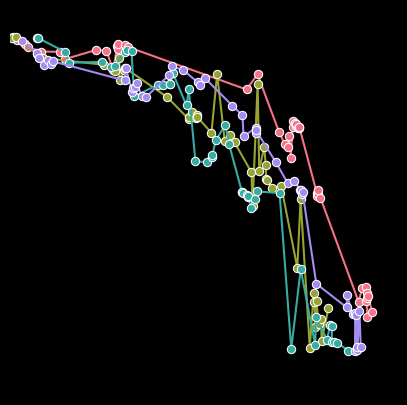

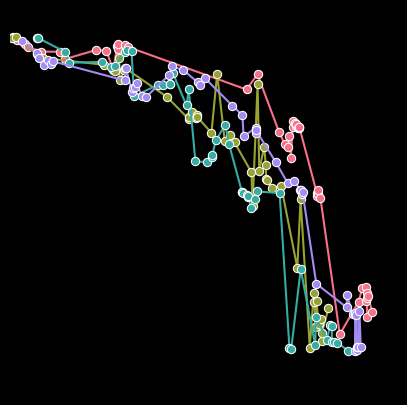

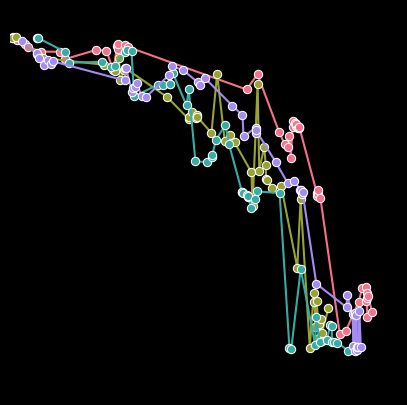

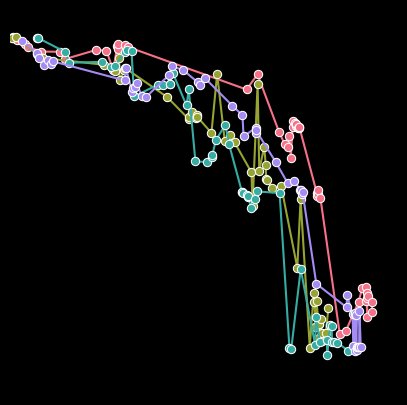

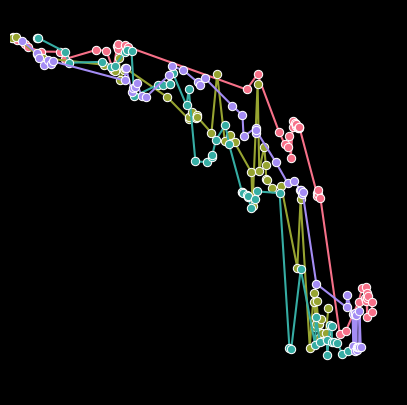

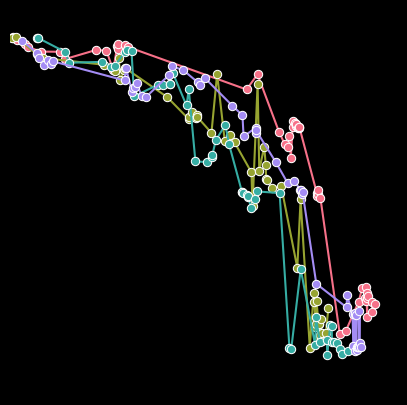

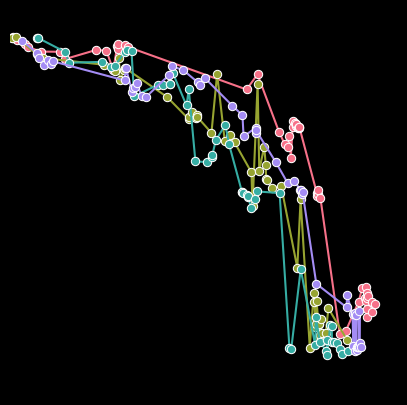

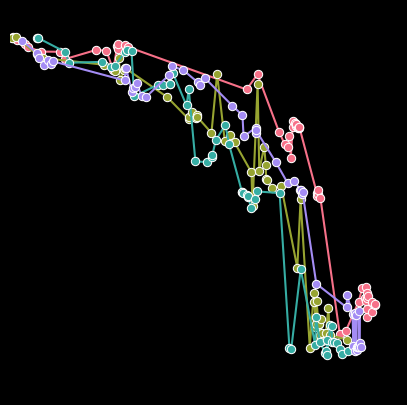

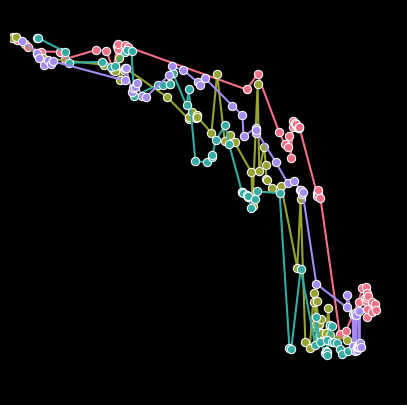

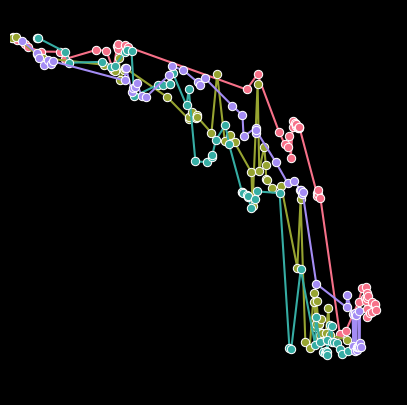

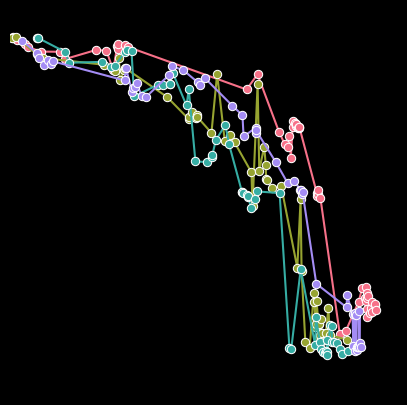

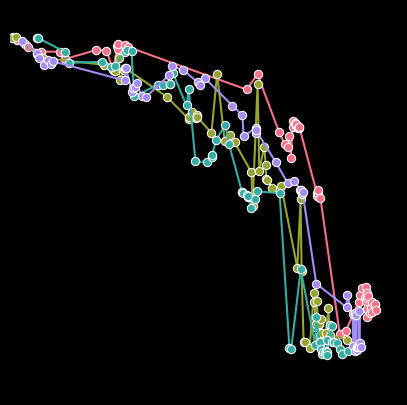

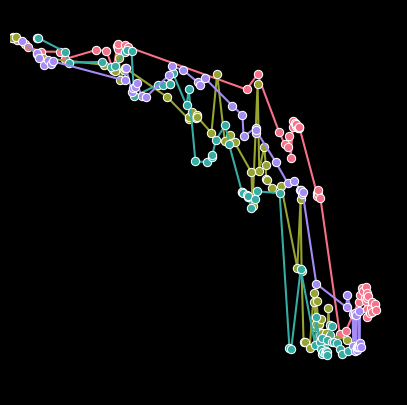

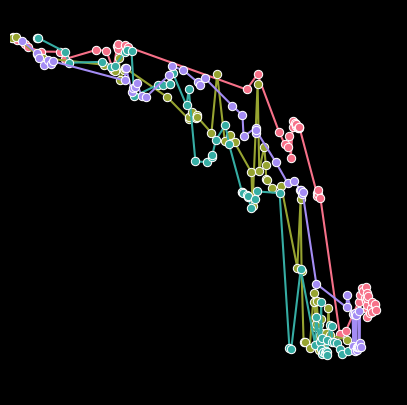

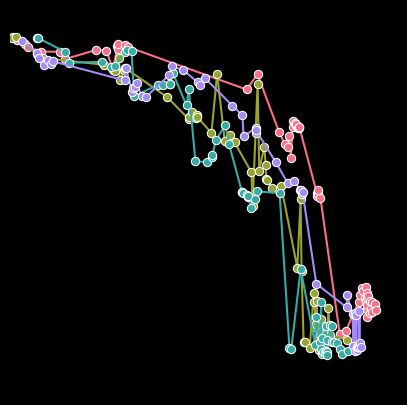

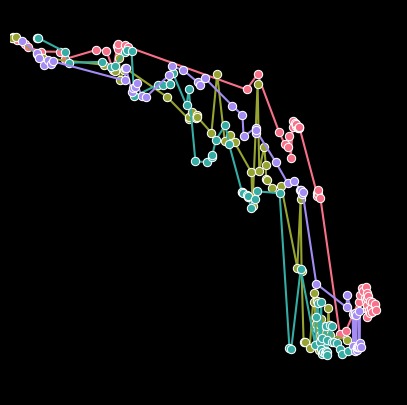

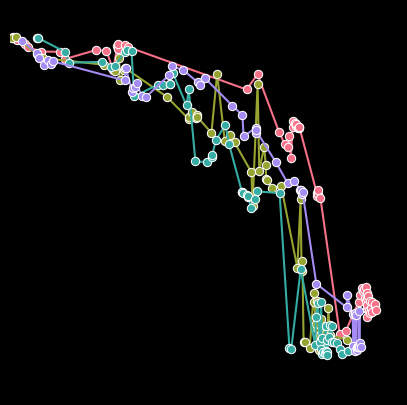

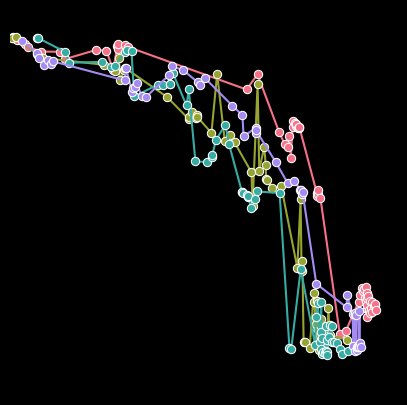

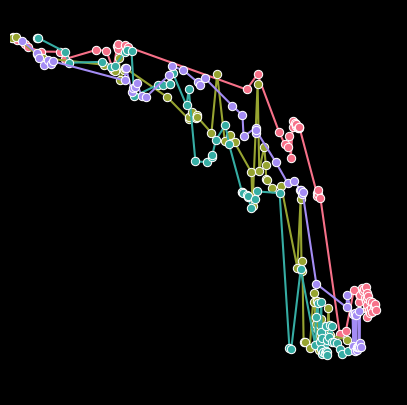

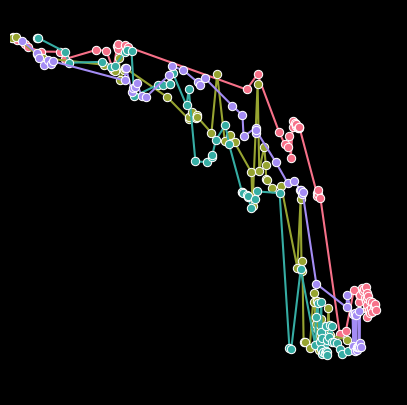

In [24]:
# create the matrix of frames
plt.style.use("dark_background")
xmale = pd.DataFrame()
n=1
to_plot = []
end=64
while True:
    # build the current age matrix
    for m,_df in enumerate(df.groupby('mouse')):
        xmale_temp = _df[1][0:0+n]
        xmale = pd.concat([xmale,xmale_temp])
    fig, ax = plt.subplots()
    fig.set_size_inches(5,5) 
    sns.lineplot(data=xmale,x='0',y='1',hue='mouse',marker='o',hue_order=['02_01','02_02','02_03','02_04'], ax=ax, 
                 legend = False,
                 palette = "husl")
    ax.set_xlim([5,15])
    ax.set_ylim([-3,8])
    sns.despine()
    plt.axis('off')
    if n>64:
        break
    n=n+1
    to_plot.append(xmale)
    xmale = pd.DataFrame()


In [25]:
xmale

,0,1,mouse,days
0,5.880433,7.236295,01_01,21
15,5.840889,7.201926,01_01,22
26,6.283502,6.997375,01_01,25
41,6.551053,7.120782,01_01,26
54,6.435153,6.987018,01_01,27
...,...,...,...,...
841,10.611572,0.878378,04_04,460
854,10.908752,0.736805,04_04,468
867,10.753272,0.975609,04_04,479
880,10.827876,0.919059,04_04,488


In [27]:
xmale.days.max()

492

Moviepy - Building video /n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana/figs/traj.mp4.
Moviepy - Writing video /n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana/figs/traj.mp4



Moviepy - Done !
Moviepy - video ready /n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana/figs/traj.mp4


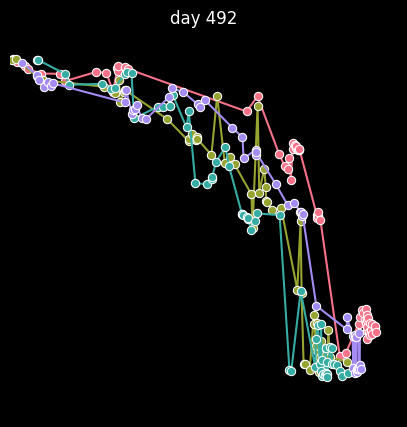

In [29]:
# importing movie py libraries
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython import display
 
# numpy array
#x = np.linspace(-2, 2, 200)
 
# duration of the video
fps=5
duration = int(np.floor(len(to_plot)/fps))
 
# matplot subplot
plt.style.use("dark_background") 
fig, ax = plt.subplots()
fig.set_size_inches(5,5) 
# method to get frames
i=0
def make_frame(t):
    global i
    global ind
    # clear
    ax.clear()
    # plotting line
    xmale=to_plot[i]
    sns.lineplot(data=xmale,x='0',y='1',hue='mouse',marker='o',hue_order=['02_01','02_02','02_03','02_04'], ax=ax, 
                 legend = False,
                 palette = "husl")
    ax.set_xlim([5,15])
    ax.set_ylim([-3,8])
    sns.despine()
    plt.axis('off')
    plt.title('day '+str(xmale.days.max()),fontsize = 12)
    #plt.title(ind[i])
    i=i+1
    # returning numpy image
    return mplfig_to_npimage(fig)
 
# creating animation
animation = VideoClip(make_frame, duration = duration)
animation.write_videofile(data_loc+"traj.mp4",fps=fps)
# displaying animation with auto play and looping
#animation.ipython_display(fps = fps, loop = False, autoplay = False)


In [ ]:
duration

In [ ]:
# prepare data
data=df.copy().reset_index()
ind = data['days'].unique()
concat = {}
for m, _df in data.groupby('mouse'):
    _df=_df.drop_duplicates(subset=['days'])
    arr = _df.drop(columns=['mouse']).set_index('days').reindex(ind).to_numpy().flatten()
    concat[m] = arr
concat = pd.DataFrame(concat).T.fillna(0)
data_pca = concat.to_numpy()

In [ ]:
# prepare data
data=df.copy().reset_index()
ind = data['days'].unique()
concat = {}
for m, _df in data.groupby('mouse'):
    _df=_df.drop_duplicates(subset=['days'])
    arr = _df.drop(columns=['mouse']).set_index('days').reindex(ind).to_numpy().flatten()
    concat[m] = arr
concat = pd.DataFrame(concat).T.fillna(0)
data_pca = concat.to_numpy()

In [ ]:
df = pd.DataFrame(X.T)
corr_coef = df.corr(method="pearson")
print(corr_coef)

(over the columns)

In [ ]:
df.groupby(['mouse','days']).mean()